<h1 align="center">
    <font size="24">
        <u>TIME SERIES ANALYSIS WITH XGBOOST AND LSTM</u>
    </font>
</h1>



<p align="center">
  <img src="https://media.giphy.com/media/3o6Ztah2Jo4BQReDIs/giphy.gif" alt="animated" width="450" height="1000">
</p>

In [7]:
import pandas as pd
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import gc
import joblib
from scipy import stats 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
import openpyxl
import os
import tensorflow as tf
import yfinance as yf
import warnings
import matplotlib
warnings.filterwarnings("ignore")

# XGBoost

In [3]:
stock_prices = yf.download("AAPL", start="2001-11-30")
SPY = yf.download("SPY", start="2001-11-30")["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
stock_prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-11-29,0.367857,0.369643,0.360536,0.364643,0.312632,202764800
2001-11-30,0.365536,0.382857,0.361607,0.380357,0.326105,303912000
2001-12-03,0.376071,0.380000,0.367857,0.375893,0.322278,181165600
2001-12-04,0.375893,0.402857,0.370000,0.400000,0.342946,380419200
2001-12-05,0.399286,0.429107,0.395893,0.424286,0.363768,568579200


In [9]:
stock_prices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5068.000000,5068.000000,5068.000000,5068.000000,5068.000000,5.068000e+03
mean,26.813484,27.097930,26.531566,26.826177,25.649412,4.275588e+08
std,35.994706,36.402208,35.605986,36.022690,35.991135,3.868372e+08
min,0.231964,0.235536,0.227143,0.234286,0.200869,3.934000e+07
25%,3.024554,3.065536,2.986429,3.025268,2.593759,1.466400e+08
50%,14.401786,14.582678,14.261607,14.423393,12.401883,3.037038e+08
75%,32.380000,32.648126,32.090000,32.404999,29.612196,5.841437e+08
max,182.630005,182.940002,179.119995,182.009995,182.009995,3.372970e+09


In [10]:
tickers = ["AAPL", "MSFT", "TSLA", "AMZN", "SPY"]

In [12]:
def sp500_log_rets(tickers):
    stock_prices = yf.download(tickers, start="2015-11-30", end="2021-11-30")["Close"]
    log_rets = {}
    for index, ticker in enumerate(tickers):
        log_rets[ticker] = np.log(stock_prices[ticker]/stock_prices[ticker].shift(1))
    return log_rets

In [13]:
log_rets = sp500_log_rets(tickers)

[*********************100%***********************]  5 of 5 completed


In [14]:
def annualized_rets(rets):

    compound = (1+rets).prod()
    n_periods = rets.shape[0]
    return compound**(365/n_periods)-1

In [20]:
#Annual rets for the selected tickers
ann_rets = {}
for ticker in log_rets.keys():
    ann_rets[ticker] = str(round(annualized_rets(log_rets[ticker])*100,2))+"%"
ann_rets

{'AAPL': '41.25%',
 'MSFT': '47.46%',
 'TSLA': '71.34%',
 'AMZN': '40.87%',
 'SPY': '18.42%'}

Text(18970, 4, '41.25%')

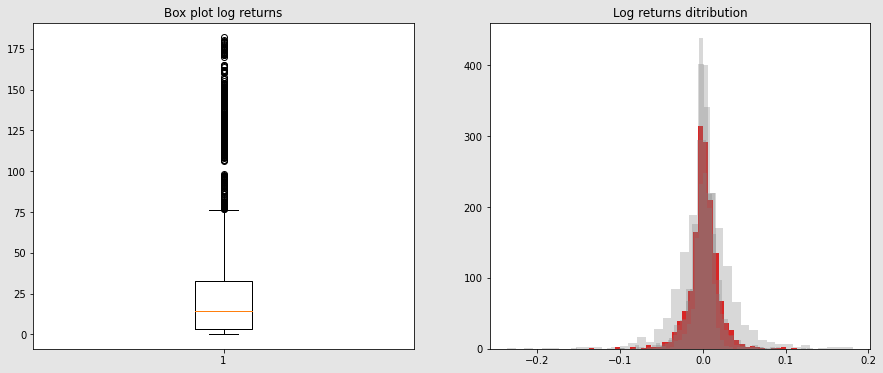

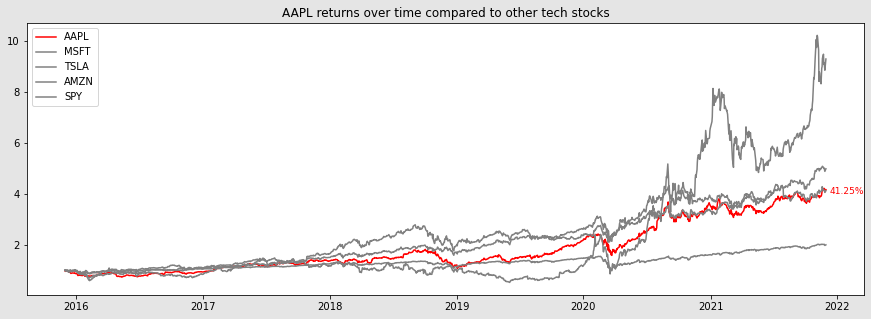

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor('grey')
fig.patch.set_alpha(0.2)
for i in log_rets.keys():
    if i=="AAPL":
        ax[1].hist(log_rets[i], bins=40, color = "red")
        ax[0].boxplot(stock_prices["Close"])
        ax[0].set_title("Box plot log returns")
        ax[1].set_title("Log returns ditribution")
    else:
        ax[1].hist(log_rets[i], bins=40, color = "grey", alpha=.3)
        ax[0].set_title("Box plot log returns")
        ax[1].set_title("Log returns ditribution")


fig,ax = plt.subplots(figsize=(15,5))
fig.patch.set_facecolor('grey')
fig.patch.set_alpha(0.2)
for i in log_rets.keys():
    if i=="AAPL":
        ax.plot((1+log_rets[i]).cumprod(), color="red")

    else:
        ax.plot((1+log_rets[i]).cumprod(), color="grey")

ax.legend(tickers)
ax.set_title("AAPL returns over time compared to other tech stocks")
ax.text(18970, 4, ann_rets["AAPL"], size=9, color='red')

## Feature Engineering

We will firt make the analysis forecasting 1 period ahead

In [37]:
stock_prices["Day"] = stock_prices.index.day
stock_prices["Month"] = stock_prices.index.day
stock_prices["Year"] = stock_prices.index.day
stock_prices["Weekday"] = stock_prices.index.weekday
stock_prices["Upper_Shape"] = stock_prices["High"]-np.maximum(stock_prices["Open"], stock_prices["Close"])
stock_prices["Lower_Shape"] = np.minimum(stock_prices["Open"], stock_prices["Close"])-stock_prices["Low"]
stock_prices["SP500"] = SPY.shift(1)
target = stock_prices["Close"].shift(1) #Notice the period ahead
stock_prices.drop("Close",1,  inplace=True)
stock_prices["Close"] = target
stock_prices.dropna(0, inplace=True)

Split between train and test set

In [38]:
train = stock_prices.iloc[:int(len(stock_prices)*.99)]
test = stock_prices.iloc[int(len(stock_prices)*.99):]

In [53]:
train_rets = np.log(train["Close"]/train["Close"].shift(1))
test_rets = np.log(test["Close"]/test["Close"].shift(1))

Text(0.5, 1.0, 'Distribution of the test set')

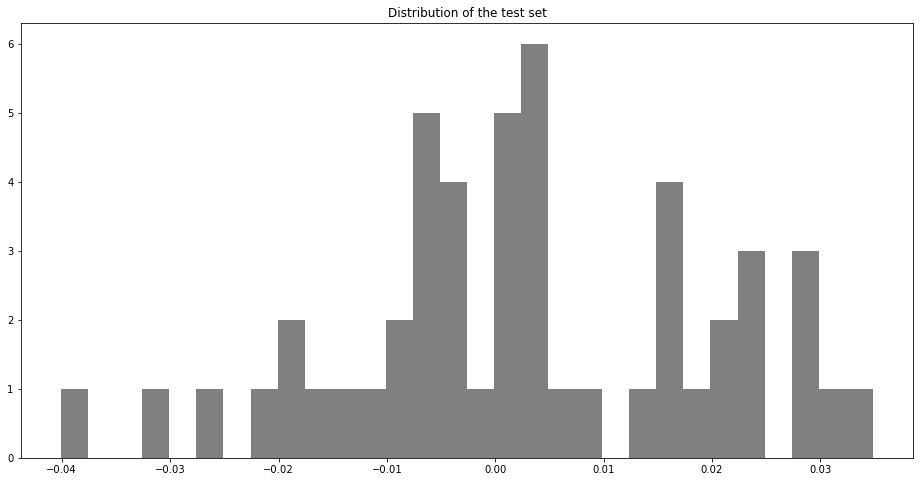

In [66]:
plt.figure(figsize=(16, 8))
plt.hist(test_rets, bins=30, color = "grey")
plt.title("Distribution of the test set")

In [39]:
print(train.shape)
print(test.shape)

(5016, 13)
(51, 13)


Here are some functions that pretend to ease us the work while applying the same algorithm on different period forecasts

In [46]:
def train_test_split(data, percentage):
    '''Splits a DataFrame in train and Test set'''
    
    assert type(stock_prices)==type(pd.DataFrame()), "Data must be in form of a DataFrame"
    
    data = data.values
    n = int(len(data)*(1-percentage))
    return data[:n], data[n:]

In [47]:
def xgb_predict(train, val):
    
    '''Function that gets the whole train data and the validation data to train on.
    Then, the predictions are returned.
    '''
    
    
    train = np.array(train)
    X, y = train[:, :-1], train[:, -1]
    
    xgb_params = {
        'eta': 0.037,
        'max_depth': 5,
        'subsample': 0.80,
        'objective': 'reg:linear',
        'eval_metric': 'mae',
        'lambda': 0.8,   
        'alpha': 0.4, 
        'base_score': np.mean(y),
        'silent': 1
    }
    
    
    
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X, y)
    
    
    joblib.dump(xgb_model, "Xboostmodel.pkl")
    
    val = np.array(val)
    pred = xgb_model.predict(val)
    return pred

In [48]:
def validate(data, percentage, window=10):
    
    '''Validation function which aimes to see the performance of the algorithm.
    Input:
        - Splitted Data
        - Percentage of Splitting training and validation set
        - The amount of future predictions that are used for validation (setted as a time window)
    
    Returns:
        - Mean Absolute Error
        - Validation Set
        - Predictions
    
    '''
    
    predictions = []
    mae = []
    
    train, val = train_test_split(data, percentage)
    
    history = [x for x in train]
    
    for i in range(len(val)):
        
        X_val, y_val = val[i:i+window, :-1], val[i:i+window, -1]
        
        pred = xgb_predict(np.vstack(history), X_val)
        predictions.append(pred)
        mae.append(mean_absolute_error(y_val, pred))
        print("MAE for {}: {}".format(i, mean_absolute_error(y_val, pred)))        
        history.append(val[i])
      
    
    return np.mean(mae), val[:-1], predictions

In [49]:
# Lets run it for a 20% train validation split
rmae, y, xgbpred = validate(train, .2)

MAE for 0: 0.8801567077636718
MAE for 1: 0.7162555694580078
MAE for 2: 0.6727699279785156
MAE for 3: 0.6264129638671875
MAE for 4: 0.6190589904785156
MAE for 5: 0.4400066375732422
MAE for 6: 0.3649452209472656
MAE for 7: 0.1944599151611328
MAE for 8: 0.19099044799804688
MAE for 9: 0.23726654052734375
MAE for 10: 0.23121795654296876
MAE for 11: 0.23689842224121094
MAE for 12: 0.2760150909423828
MAE for 13: 0.34491119384765623
MAE for 14: 0.3614067077636719
MAE for 15: 0.35598411560058596
MAE for 16: 0.3669452667236328
MAE for 17: 0.27657127380371094
MAE for 18: 0.32836570739746096
MAE for 19: 0.2896942138671875
MAE for 20: 0.25538101196289065
MAE for 21: 0.21323699951171876
MAE for 22: 0.22639007568359376
MAE for 23: 0.15050697326660156
MAE for 24: 0.2816192626953125
MAE for 25: 0.27232513427734373
MAE for 26: 0.29967193603515624
MAE for 27: 0.2934455871582031
MAE for 28: 0.2801532745361328
MAE for 29: 0.29488143920898435
MAE for 30: 0.2120067596435547
MAE for 31: 0.2120380401611328
MAE

MAE for 259: 0.6834747314453125
MAE for 260: 0.820132827758789
MAE for 261: 0.9831764221191406
MAE for 262: 0.8774551391601563
MAE for 263: 1.00400390625
MAE for 264: 0.9916000366210938
MAE for 265: 0.9246910095214844
MAE for 266: 0.9626575469970703
MAE for 267: 0.6946922302246094
MAE for 268: 0.7036880493164063
MAE for 269: 0.5404617309570312
MAE for 270: 0.49044075012207033
MAE for 271: 0.38162078857421877
MAE for 272: 0.4175933837890625
MAE for 273: 0.4620639801025391
MAE for 274: 0.5825431823730469
MAE for 275: 0.4896636962890625
MAE for 276: 0.553271484375
MAE for 277: 0.5204727172851562
MAE for 278: 0.4713935852050781
MAE for 279: 0.47930145263671875
MAE for 280: 0.7034587860107422
MAE for 281: 0.6613548278808594
MAE for 282: 0.7757247924804688
MAE for 283: 0.7805179595947266
MAE for 284: 0.8070991516113282
MAE for 285: 0.7300575256347657
MAE for 286: 0.5975490570068359
MAE for 287: 0.7307647705078125
MAE for 288: 0.6552078247070312
MAE for 289: 0.7234771728515625
MAE for 290: 0.

MAE for 516: 0.6431182861328125
MAE for 517: 0.6473495483398437
MAE for 518: 0.8182014465332031
MAE for 519: 0.9057975769042969
MAE for 520: 1.0709686279296875
MAE for 521: 1.16331787109375
MAE for 522: 1.4803192138671875
MAE for 523: 1.816747283935547
MAE for 524: 2.2745330810546873
MAE for 525: 2.1011085510253906
MAE for 526: 2.4985366821289063
MAE for 527: 2.59569091796875
MAE for 528: 2.9107284545898438
MAE for 529: 3.0473068237304686
MAE for 530: 2.994983673095703
MAE for 531: 2.0692070007324217
MAE for 532: 2.033064270019531
MAE for 533: 2.440241241455078
MAE for 534: 3.111192321777344
MAE for 535: 3.3591094970703126
MAE for 536: 3.083806610107422
MAE for 537: 3.5773078918457033
MAE for 538: 2.9137672424316405
MAE for 539: 3.9653900146484373
MAE for 540: 3.8314422607421874
MAE for 541: 3.436991882324219
MAE for 542: 2.6896514892578125
MAE for 543: 3.2460037231445313
MAE for 544: 3.1481918334960937
MAE for 545: 3.608470916748047
MAE for 546: 3.691059112548828
MAE for 547: 1.966898

MAE for 776: 1.3705238342285155
MAE for 777: 1.3341461181640626
MAE for 778: 1.5280296325683593
MAE for 779: 1.7855697631835938
MAE for 780: 1.9658775329589844
MAE for 781: 3.400354766845703
MAE for 782: 3.4339637756347656
MAE for 783: 3.3851104736328126
MAE for 784: 4.412821960449219
MAE for 785: 4.6872611999511715
MAE for 786: 4.074647521972656
MAE for 787: 4.893118286132813
MAE for 788: 4.447360229492188
MAE for 789: 4.574995422363282
MAE for 790: 2.9131072998046874
MAE for 791: 1.628411865234375
MAE for 792: 1.289299774169922
MAE for 793: 1.2872459411621093
MAE for 794: 1.56942138671875
MAE for 795: 1.541020965576172
MAE for 796: 1.3326873779296875
MAE for 797: 1.6386375427246094
MAE for 798: 1.9916542053222657
MAE for 799: 1.7734886169433595
MAE for 800: 2.6603988647460937
MAE for 801: 3.0921066284179686
MAE for 802: 3.581897735595703
MAE for 803: 3.6064353942871095
MAE for 804: 3.5545166015625
MAE for 805: 3.807952880859375
MAE for 806: 3.705097961425781
MAE for 807: 3.3575256347

In [52]:
print(f"The average MAE for this analysis is: {round(rmae, 3)}")

The average MAE for this analysis is: 1.404


### Evaluation on the Test Set

In [67]:
X_test = np.array(test)[:, :-1]
y_test = np.array(test)[:, -1]

In [69]:
#Lets load the model for usage
model = joblib.load("Xboostmodel.pkl")

In [70]:
test_pred = model.predict(X_test)

In [71]:
test_mae =  mean_absolute_error(y_test, test_pred)

In [87]:
pd.DataFrame([test_pred, y_test], columns=test.index, index=["Test Prediction", "Real Test Value"]).T.head()

,Test Prediction,Real Test Value
Date,,
2021-11-03,149.951462,150.020004
2021-11-04,149.826141,151.490005
2021-11-05,153.336060,150.960007
2021-11-08,148.849625,151.279999
2021-11-09,150.418060,150.440002


In [90]:
results = pd.DataFrame([test_pred, y_test], columns=test.index, index=["Test Prediction", "Real Test Value"]).T

Text(0.5, 1.0, 'The MAE for this period is: 12.949')

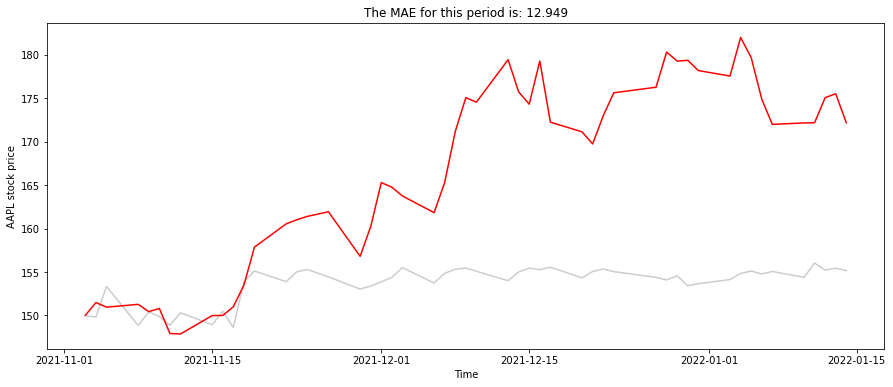

In [133]:
plt.figure(figsize=(15, 6))

plt.plot(results["Test Prediction"], color="grey", alpha=.4)
plt.plot(results["Real Test Value"], color="red")

plt.xlabel("Time")
plt.ylabel("AAPL stock price")
plt.title(f"The MAE for this period is: {round(test_mae, 3)}")

# Conclusion

In future updates of the code I will include an analysis of further time periods, and also a hybrid combination with an LSTM. 
Moreover, this analysis makes some assumptions that I wanted to mention aswell in further updated versions.
Stay tuned!